In [1]:
# part 1 experimentation: Evaluate the pretrained model on bright sunny test images
# major library dependencies: jupyter, numpy, matplotlib, pytorch, scikit-image, pillow

import torch
from dataset import camvidLoader
import numpy as np
import pandas as pd
# plot the test
from dataset import from_label_to_rgb
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.io import imsave
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

device = 'cpu' # can be set to "cuda" if you have a GPU
unet = torch.load('camvid_sunny_model.pt', map_location=torch.device(device))
data_root = './CamVid/sunny'
test_data = camvidLoader(root=data_root, split='test', is_aug=False, img_size = [256, 256], is_pytorch_transform=True)

num_classes = 14 # number of classes is always 14 for this project.
labels = ['Sky', 'Building', 'Pole', 'Road', 'LaneMarking', 'SideWalk', 'Pavement', 'Tree', 'SignSymbol', 
          'Fence', 'Car_Bus', 'Pedestrian', 'Bicyclist', 'Others']

# define model evaluation functions

In [2]:
# implement the evaluation metric functions here. 
# calculate the accuracy for each image
def global_accuracy_metric(y_true, y_pred):
    return np.sum(y_true == y_pred)/y_pred.size

# calculate the iou for each category
def IoU_metric(y_true, y_pred):

    iou_per_image = []
    
    for i in range(num_classes):
        intersection = np.logical_and(y_pred == i, y_true == i).sum()
        union = np.logical_or(y_pred == i, y_true == i).sum()
        
        # if the union is 0, then the iou should be null
        # otherwise, the iou is intersection/union
        if union == 0:
            iou = np.NAN
        else:
            iou = intersection/union
            
        iou_per_image.append(iou)

    return iou_per_image

In [3]:
# load the test dataset for evaluation
num_workers = 1
batch_size = 8

test_loader = DataLoader(test_data, num_workers=num_workers, batch_size=batch_size, shuffle=False, drop_last=False)

# write the testing loop

In [5]:
# create a file to store checkpoint model parameters
test_result_dir = './test_internal_data/'
if not os.path.exists(test_result_dir):
    os.makedirs(test_result_dir)

global_acc = []
perclass_acc = []
img_file = []

# to segment predict and gt label plots
padding = np.ones((256, 10, 3), dtype=np.uint8) * 255  

# start evaluate
unet.eval()

for idx_batch, (imagergb, labelmask, filename) in enumerate(tqdm(test_loader)):

    img_file.extend(filename)
    
    with torch.no_grad(): 

        x = imagergb.to(device) 
        y_ = labelmask.to(device) 
        y = unet(x) 

        for idx in range(0, y.shape[0]):

            # y_pred with the most likely labels
            max_index = torch.argmax(y[idx], dim=0).cpu().int().numpy()
            gt_correct_format = y_[idx].cpu().int().numpy()

            # calculate the global accuracy of each image
            correct_prediction = global_accuracy_metric(gt_correct_format, max_index)
            global_acc.append(correct_prediction)

            # calculate the iou per class of each image
            iou_per_image = IoU_metric(gt_correct_format, max_index)
            perclass_acc.append(iou_per_image)

            # store the predicted image and ground truth labels
            result_vis = np.concatenate((from_label_to_rgb(gt_correct_format), 
                                         padding,
                                         from_label_to_rgb(max_index)), axis=1)
            result_vis_for_saving = (result_vis * 255.0).astype(np.uint8)
            imsave(test_result_dir + "{}_P.png".format(filename[idx].split('/')[-1].split('.')[0]), result_vis_for_saving)


100%|██████████| 18/18 [00:49<00:00,  2.76s/it]


## calculate global image accuracy and per-class accuracy for the entire dataset

In [6]:
# print and calculate the global image accuracy 
print(f'The global accuracy overall image is: {np.mean(global_acc)}')

# print and calculate the average mIOU
overall_class_iou = np.nanmean(perclass_acc, axis=0)
print(f'The average mIoU scores is: {np.nanmean(overall_class_iou)}\n')

# print and calculate the IOU per class
for idx in range(num_classes):
    print(f'The overall IOU scores for class {labels[idx]} is {overall_class_iou[idx]}')

The global accuracy overall image is: 0.851022447858538
The average mIoU scores is: 0.37976918994566145

The overall IOU scores for class Sky is 0.8850991728561254
The overall IOU scores for class Building is 0.700447889931736
The overall IOU scores for class Pole is 0.0
The overall IOU scores for class Road is 0.9106316246516621
The overall IOU scores for class LaneMarking is 0.42020705726132085
The overall IOU scores for class SideWalk is 0.624671748374085
The overall IOU scores for class Pavement is nan
The overall IOU scores for class Tree is 0.5313703404604849
The overall IOU scores for class SignSymbol is 0.0
The overall IOU scores for class Fence is 0.09576025405974563
The overall IOU scores for class Car_Bus is 0.5403472450964251
The overall IOU scores for class Pedestrian is 0.2218313286438959
The overall IOU scores for class Bicyclist is 0.0
The overall IOU scores for class Others is 0.006632807958117115


# check the reasons for nan in iou per-class

In [ ]:
train_data_img = camvidLoader(root=data_root, split='train', is_aug=False, img_size = [256, 256], 
                             is_pytorch_transform = False, aug = None) 
test_data_img = camvidLoader(root=data_root, split='test', is_aug=False, img_size = [256, 256], 
                             is_pytorch_transform = False, aug = None) 

# check if all labels are appeared in train dataset
all_labels_train = []
for images, label, img_path in test_data_img:
    unique_labels_train = [i for i in set(label.flatten())]
    all_labels_train.append(unique_labels_train)

flat_list_train = [item for sublist in all_labels_train for item in sublist]
unique_numbers_train = set(flat_list_train)

# check if all labels are appeared in test dataset
all_labels_test = []
for images, label, img_path in test_data_img:
    unique_labels_test = [i for i in set(label.flatten())]
    all_labels_test.append(unique_labels_test)

flat_list_test = [item for sublist in all_labels_test for item in sublist]
unique_numbers_test = set(flat_list_test)

print(f'labels appeared in train datasets are: {unique_numbers_train}')
print(f'labels appeared in test datasets are: {unique_numbers_test}')

# rank gloabl accuracy and average mIOU

In [7]:
# find the accuracy and iou rank that has big difference
overall_mean_iou = np.nanmean(perclass_acc, axis=1)
rank_list = []

# add the image file path, acc, iou into a dataframe
acc_iou_compare = pd.DataFrame({
    'img': img_file,
    'acc': global_acc, 
    'iou': overall_mean_iou
}, index=range(len(overall_mean_iou)))

# sort the ranks for acc and iou
acc_sort = sorted(acc_iou_compare['acc'])
iou_sort = sorted(acc_iou_compare['iou'])

# substract iou rank from acc rank to find their differences
for i in range(len(acc_iou_compare)):
    acc_rank = acc_sort.index(acc_iou_compare.iloc[i]['acc'])
    iou_rank = iou_sort.index(acc_iou_compare.iloc[i]['iou'])
    rank_difference = acc_rank-iou_rank
    rank_list.append(rank_difference)

acc_iou_compare['rank_difference'] = rank_list

# sort the rank difference in descend order
acc_iou_compare.sort_values(by='rank_difference', ascending=False)

,img,acc,iou,rank_difference
128,./CamVid/sunny/test/0006R0_f03090.png,0.928009,0.357992,125
126,./CamVid/sunny/test/0016E5_06840.png,0.910294,0.385843,90
0,./CamVid/sunny/test/Seq05VD_f03270.png,0.874481,0.366930,74
120,./CamVid/sunny/test/0016E5_04470.png,0.872665,0.372808,65
125,./CamVid/sunny/test/0016E5_04500.png,0.875046,0.384544,65
...,...,...,...,...
92,./CamVid/sunny/test/Seq05VD_f01740.png,0.826538,0.451815,-74
93,./CamVid/sunny/test/0006R0_f03780.png,0.811234,0.443847,-74
54,./CamVid/sunny/test/0016E5_08580.png,0.780579,0.441658,-87
83,./CamVid/sunny/test/0016E5_01620.png,0.781921,0.448700,-94


# show image with high acc rank while low iou rank

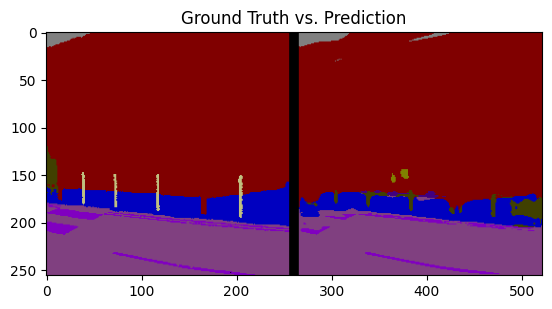

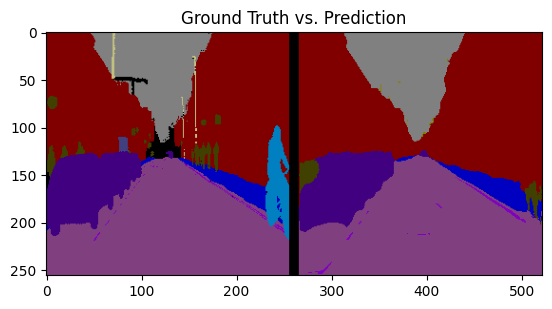

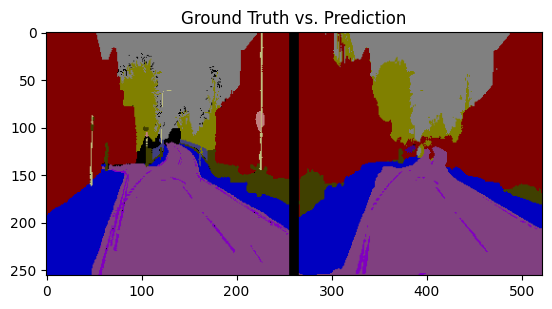

In [8]:
from PIL import Image
import matplotlib.pyplot as plt

pred_1 = './test_internal_data/0006R0_f03090_p.png'
pred_2 = './test_internal_data/0016E5_06840_p.png'
pred_3 = './test_internal_data/Seq05VD_f03270_p.png'

# 创建图像对象
imgs = [Image.open(pred_1), Image.open(pred_2), Image.open(pred_3)]

# 依次展示图像
for img in imgs:
    plt.imshow(img)
    plt.title('Ground Truth vs. Prediction')
    plt.show()
    plt.close()


# show image with low acc rank while high iou rank

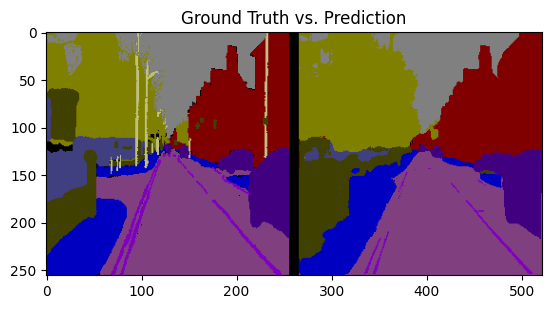

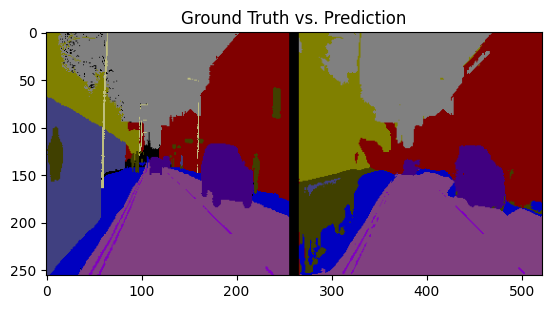

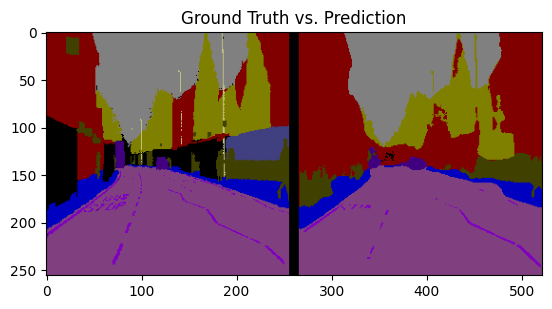

In [9]:
pred_1 = './test_internal_data/Seq05VD_f01410_p.png'
pred_2 = './test_internal_data/0016E5_01620_p.png'
pred_3 = './test_internal_data/0016E5_08580_p.png'

# 创建图像对象
imgs = [Image.open(pred_1), Image.open(pred_2), Image.open(pred_3)]

# 依次展示图像
for img in imgs:
    plt.imshow(img)
    plt.title('Ground Truth vs. Prediction')
    plt.show()
    plt.close()
